In [1]:
import jax
import flax
import jax.numpy as jnp
import flax.linen as nn

import os
import time
from functools import partial

import numpy as np
from matplotlib import pyplot as plt

print('Jax version', jax.__version__)
print('Flax version', flax.__version__)
random_key = jax.random.PRNGKey(0)

Jax version 0.4.1
Flax version 0.5.1


In [8]:
from layers import squeeze, unsqueeze
from layers import Split
from layers import ActNorm, Conv1x1, AffineCoupling

from model import FlowStep, GLOW

from utils import summarize_jax_model
from utils import plot_image_grid

In [9]:
@jax.vmap
def get_logpz(z, priors):
    logpz = 0
    for zi, priori in zip(z, priors):
        if priori is None:
            logsigma = jnp.zeros(zi.shape)
        else:
            mu, logsigma = jnp.split(priori, 2, axis=-1)
        logpz += jnp.sum(- logsigma - 0.5 * jnp.log(2 * jnp.pi) 
                         - 0.5 * (zi - mu) ** 2 / jnp.exp(2 * logsigma))
    return logpz

In [10]:
def map_fn(image_path, num_bits=5, size=256, training=True):
    """Read image file, quantize and map to [-0.5, 0.5] range.
    If num_bits = 8, there is no quantization effect."""
    image = tf.io.decode_jpeg(tf.io.read_file(image_path))
    # Resize input image
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (size, size))
    image = tf.clip_by_value(image, 0., 255.)
    # Discretize to the given number of bits
    if num_bits < 8:
        image = tf.floor(image / 2 ** (8 - num_bits))
    # Send to [-1, 1]
    num_bins = 2 ** num_bits
    image = image / num_bins - 0.5
    if training:
        image = image + tf.random.uniform(tf.shape(image), 0, 1. / num_bins)
    return image


@jax.jit
def postprocess(x, num_bits):
    """Map [-0.5, 0.5] quantized images to uint space"""
    num_bins = 2 ** num_bits
    x = jnp.floor((x + 0.5) * num_bins)
    x *= 256. / num_bins
    return jnp.clip(x, 0, 255).astype(jnp.uint8)

In [11]:
def sample(model, 
           params, 
           eps=None, 
           shape=None, 
           sampling_temperature=1.0, 
           key=jax.random.PRNGKey(0),
           postprocess_fn=None, 
           save_path=None,
           display=True):
    """Sampling only requires a call to the reverse pass of the model"""
    if eps is None:
        zL = jax.random.normal(key, shape) 
    else: 
        zL = eps[-1]
    y, *_ = model.apply(params, zL, eps=eps, sampling_temperature=sampling_temperature, reverse=True)
    if postprocess_fn is not None:
        y = postprocess_fn(y)
    plot_image_grid(y, save_path=save_path, display=display,
                    title=None if save_path is None else save_path.rsplit('.', 1)[0].rsplit('/', 1)[-1])
    return y

## Training loop

In [12]:
def train_glow(train_ds,
               val_ds=None,
               num_samples=9,
               image_size=256,
               num_channels=3,
               num_bits=5,
               init_lr=1e-3,
               num_epochs=1,
               num_sample_epochs=1,
               num_warmup_epochs=10,
               num_save_epochs=1,
               steps_per_epoch=1,
               K=32,
               L=3,
               nn_width=512,
               sampling_temperature=0.7,
               learn_top_prior=True,
               key=jax.random.PRNGKey(0),
               **kwargs):
    """Simple training loop.
    Args:
        train_ds: Training dataset iterator (e.g. tensorflow dataset)
        val_ds: Validation dataset (optional)
        num_samples: Number of samples to generate at each epoch
        image_size: Input image size
        num_channels: Number of channels in input images
        num_bits: Number of bits for discretization
        init_lr: Initial learning rate (Adam)
        num_epochs: Numer of training epochs
        num_sample_epochs: Visualize sample at this interval
        num_warmup_epochs: Linear warmup of the learning rate to init_lr
        num_save_epochs: save mode at this interval
        steps_per_epochs: Number of steps per epochs
        K: Number of flow iterations in the GLOW model
        L: number of scales in the GLOW model
        nn_width: Layer width in the Affine Coupling Layer
        sampling_temperature: Smoothing temperature for sampling from the 
            Gaussian priors (1 = no effect)
        learn_top_prior: Whether to learn the prior for highest latent variable zL.
            Otherwise, assumes standard unit Gaussian prior
        key: Random seed
    """
    del kwargs
    # Init model
    model = GLOW(K=K,
                 L=L, 
                 nn_width=nn_width, 
                 learn_top_prior=learn_top_prior,
                 key=key)
    
    # Init optimizer and learning rate schedule
    params = model.init(random_key, next(train_ds))
    opt = flax.optim.Adam(learning_rate=init_lr).create(params)
    
    def lr_warmup(step):
        return init_lr * jnp.minimum(1., step / (num_warmup_epochs * steps_per_epoch + 1e-8))
    
    # Helper functions for training
    bits_per_dims_norm = np.log(2.) * num_channels * image_size**2
    @jax.jit
    def get_logpx(z, logdets, priors):
        logpz = get_logpz(z, priors)
        logpz = jnp.mean(logpz) / bits_per_dims_norm        # bits per dimension normalization
        logdets = jnp.mean(logdets) / bits_per_dims_norm
        logpx = logpz + logdets - num_bits                  # num_bits: dequantization factor
        return logpx, logpz, logdets
        
    @jax.jit
    def train_step(opt, batch):
        def loss_fn(params):
            _, z, logdets, priors = model.apply(params, batch, reverse=False)
            logpx, logpz, logdets = get_logpx(z, logdets, priors)
            return - logpx, (logpz, logdets)
        logs, grad = jax.value_and_grad(loss_fn, has_aux=True)(opt.target)
        opt = opt.apply_gradient(grad, learning_rate=lr_warmup(opt.state.step))
        return logs, opt
    
    # Helper functions for evaluation 
    @jax.jit
    def eval_step(params, batch):
        _, z, logdets, priors = model.apply(params, batch, reverse=False)
        return - get_logpx(z, logdets, priors)[0]
    
    # Helper function for sampling from random latent fixed during training for comparison
    eps = []
    if not os.path.exists("samples"): os.makedirs("samples")
    if not os.path.exists("weights"): os.makedirs("weights")
    for i in range(L):
        expected_h = image_size // 2**(i + 1)
        expected_c = num_channels * 2**(i + 1)
        if i == L - 1: expected_c *= 2
        eps.append(jax.random.normal(key, (num_samples, expected_h, expected_h, expected_c)))
    sample_fn = partial(sample, eps=eps, key=key, display=False,
                        sampling_temperature=sampling_temperature,
                        postprocess_fn=partial(postprocess, num_bits=num_bits))
    
    # Train
    print("Start training...")
    print("Available jax devices:", jax.devices())
    print()
    bits = 0.
    start = time.time()
    try:
        for epoch in range(num_epochs):
            # train
            for i in range(steps_per_epoch):
                batch = next(train_ds)
                loss, opt = train_step(opt, batch)
                print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                      f"\033[93m[Batch {i + 1}/{steps_per_epoch}]\033[0m"
                      f" loss = {loss[0]:.5f},"
                      f" (log(p(z)) = {loss[1][0]:.5f},"
                      f" logdet = {loss[1][1]:.5f})", end='')
                if np.isnan(loss[0]):
                    print("\nModel diverged - NaN loss")
                    return None, None
                
                step = epoch * steps_per_epoch + i + 1
                if step % int(num_sample_epochs * steps_per_epoch) == 0:
                    sample_fn(model, opt.target, 
                              save_path=f"samples/step_{step:05d}.png")

            # eval on one batch of validation samples 
            # + generate random sample
            t = time.time() - start
            if val_ds is not None:
                bits = eval_step(opt.target, next(val_ds))
            print(f"\r\033[92m[Epoch {epoch + 1}/{num_epochs}]\033[0m"
                  f"[{int(t // 3600):02d}h {int((t % 3600) // 60):02d}mn]"
                  f" train_bits/dims = {loss[0]:.3f},"
                  f" val_bits/dims = {bits:.3f}" + " " * 50)
            
            # Save parameters
            if (epoch + 1) % num_save_epochs == 0 or epoch == num_epochs - 1:
                with open(f'weights/model_epoch={epoch + 1:03d}.weights', 'wb') as f:
                    f.write(flax.serialization.to_bytes(opt.target))
    except KeyboardInterrupt:
        print(f"\nInterrupted by user at epoch {epoch + 1}")
        
    # returns final model and parameters
    return model, opt.target

**Note on multi-devices training:** To extend the code for training on multi-devices we can make use of the `jax.vmap` operator (parallelize across XLA devices) instead of `jax.jit`, we also need to share the current parameters with all the devices (use `flax.jax_utils.replicate` on the optimizer before training), and finally to split the data across the devices, which can be handled with the `tf.data` in the input pipeline. [There is a more complete tutorial with an example here](https://flax.readthedocs.io/en/stable/howtos/ensembling.html)

# Experiments

**Note:** the current model was trained in a Kaggle notebook, with some computation restrictions: Therefore it was run for 12 epochs due to time limits (roughly 40k training steps) + smaller flow depth (K = 16 instead of 32) to fit into single GPU memory

In [17]:
# Data hyperparameters for 1 GPU training
# Some small changes to the original model so 
# everything fits in memory
# In particular, I had  to use shallower
# flows (smaller K value)
config_dict = {
    'image_path': "../lfw/lfw-deepfunneled/lfw-deepfunneled",
    'train_split': 0.7,
    'image_size': 32,
    'num_channels': 3,
    'num_bits': 8, ##changed from 5 to 8
    'batch_size': 4,
    'K': 16,
    'L': 3,
    'nn_width': 512, 
    'learn_top_prior': True,
    'sampling_temperature': 0.7,
    'init_lr': 1e-3,
    'num_epochs': 13,
    'num_warmup_epochs': 1,
    'num_sample_epochs': 0.2, # Fractional epochs for sampling because one epoch is quite long 
    'num_save_epochs': 5,
}

output_hw = config_dict["image_size"] // 2 ** config_dict["L"]
output_c = config_dict["num_channels"] * 4**config_dict["L"] // 2**(config_dict["L"] - 1)
config_dict["sampling_shape"] = (output_hw, output_hw, output_c)

## Loading the data

In [23]:
import glob
import tensorflow as tf
import tensorflow_datasets as tfds
tf.config.experimental.set_visible_devices([], 'GPU')

def get_train_dataset(image_path, image_size, num_bits, batch_size, skip=None, **kwargs):
    del kwargs
    train_ds = tf.data.Dataset.list_files(f"{image_path}/*/*.jpg")
    if skip is not None:
        train_ds = train_ds.skip(skip)
    train_ds = train_ds.shuffle(buffer_size=20000)
    train_ds = train_ds.map(partial(map_fn, size=image_size, num_bits=num_bits, training=True))
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.repeat()
    return iter(tfds.as_numpy(train_ds))


def get_val_dataset(image_path, image_size, num_bits, batch_size, 
                    take=None, repeat=False, **kwargs):
    del kwargs
    val_ds = tf.data.Dataset.list_files(f"{image_path}/*/*.jpg")
    if take is not None:
        val_ds = val_ds.take(take)
    val_ds = val_ds.map(partial(map_fn, size=image_size, num_bits=num_bits, training=False))
    val_ds = val_ds.batch(batch_size)
    if repeat:
        val_ds = val_ds.repeat()
    return iter(tfds.as_numpy(val_ds))

## Einops

In [24]:
## Einops
import numpy as np

from PIL.Image import fromarray
from IPython import get_ipython


def display_np_arrays_as_images():
    def np_to_png(a):
        if 2 <= len(a.shape) <= 3:
            return fromarray(np.array(np.clip(a, 0, 1) * 255, dtype='uint8'))._repr_png_()
        else:
            return fromarray(np.zeros([1, 1], dtype='uint8'))._repr_png_()

    def np_to_text(obj, p, cycle):
        if len(obj.shape) < 2:
            print(repr(obj))
        if 2 <= len(obj.shape) <= 3:
            pass
        else:
            print('<array of shape {}>'.format(obj.shape))

    get_ipython().display_formatter.formatters['image/png'].for_type(np.ndarray, np_to_png)
    get_ipython().display_formatter.formatters['text/plain'].for_type(np.ndarray, np_to_text)


from IPython.display import display_html

_style_inline = """<style>
.einops-answer {
    color: transparent;
    padding: 5px 15px;
    background-color: #def;
}
.einops-answer:hover { color: blue; } 
</style>
"""


def guess(x):
    display_html(
        _style_inline
        + "<h4>Answer is: <span class='einops-answer'>{x}</span> (hover to see)</h4>".format(x=tuple(x)),
        raw=True)
        
import einops
import numpy as np
from PIL import Image
display_np_arrays_as_images()

In [25]:
%%time
num_images = len(glob.glob(f"{config_dict['image_path']}/*/*.jpg"))
config_dict['steps_per_epoch'] = num_images // config_dict['batch_size']
train_split = int(config_dict['train_split'] * num_images)
print(f"{num_images} training images")
print(f"{config_dict['steps_per_epoch']} training steps per epoch")

#Train data
train_ds = get_train_dataset(**config_dict, skip=train_split)

# Val data
# During training we'll only evaluate on one batch of validation 
# to save on computations
val_ds = get_val_dataset(**config_dict, take=config_dict['batch_size'], repeat=True)

13233 training images
3308 training steps per epoch
CPU times: total: 14.2 s
Wall time: 6.48 s


In [ ]:
##WIP
test_image = "../lfw/lfw-deepfunneled/lfw-deepfunneled/"

13233 training images
3308 training steps per epoch


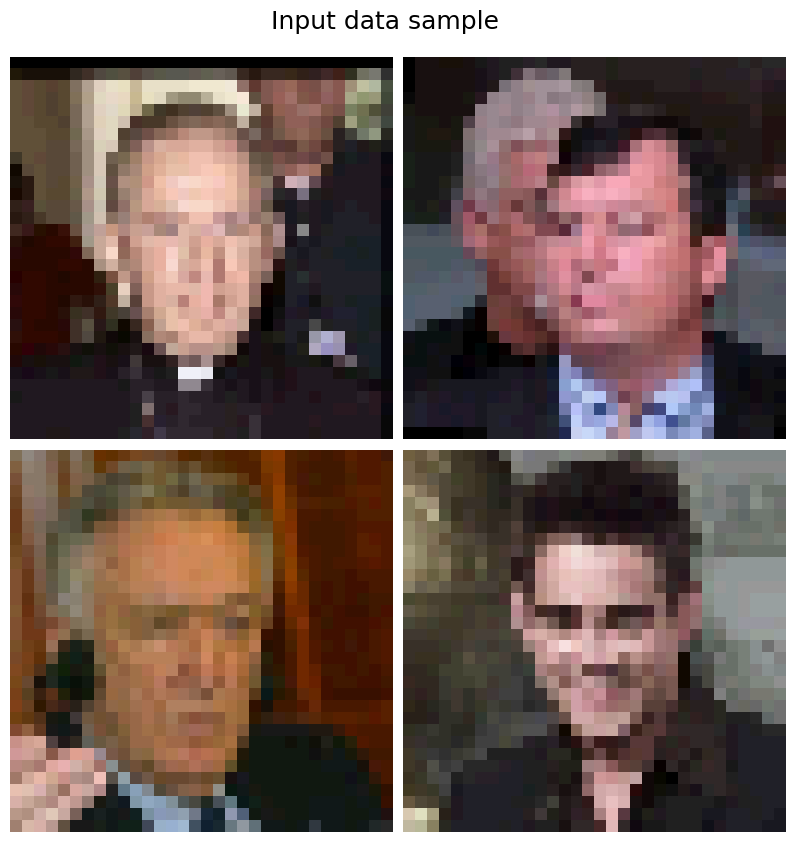

CPU times: total: 31.5 s
Wall time: 16.2 s


In [15]:
# Sample
plot_image_grid(postprocess(next(val_ds), num_bits=config_dict['num_bits'])[:25], 
                 title="Input data sample")

## Train

In [18]:
model, params = train_glow(train_ds, val_ds=val_ds, **config_dict)

c:\Users\cupca\Anaconda3\envs\jax_nf\lib\site-packages\flax\optim\base.py:49: DeprecationWarning: Use `optax` instead of `flax.optim`. Refer to the update guide https://flax.readthedocs.io/en/latest/howtos/optax_update_guide.html for detailed instructions.
  warnings.warn(


Start training...
Available jax devices: [CpuDevice(id=0)]



c:\Users\cupca\Anaconda3\envs\jax_nf\lib\site-packages\flax\core\scope.py:740: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
c:\Users\cupca\Anaconda3\envs\jax_nf\lib\site-packages\flax\core\scope.py:741: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)
c:\Users\cupca\Anaconda3\envs\jax_nf\lib\site-packages\flax\optim\base.py:90: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  params_flat, treedef = jax.tree_flatten(params)
c:\Users\cupca\Anaconda3\envs\jax_nf\lib\site-packages\flax\optim\base.py:97: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  new_params = jax.tree_unflatten(treede

In [ ]:
print("Random samples evolution during training")
from PIL import Image

# filepaths
fp_in = "samples/step_*.png"
fp_out = "sample_evolution.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [ ]:
from IPython.core.display import display, HTML
display(HTML('<img src="sample_evolution.gif">'))

### Evaluation

In [ ]:
# Optional, example code to load trained weights
if False:
    model = GLOW(K=config_dict['K'],
                 L=config_dict['L'], 
                 nn_width=config_dict['nn_width'], 
                 learn_top_prior=config_dict['learn_top_prior'])

    with open('weights/model_epoch=100.weights', 'rb') as f:
        params = model.init(random_key, jnp.zeros((config_dict['batch_size'],
                                                     config_dict['image_size'],
                                                     config_dict['image_size'],
                                                     config_dict['num_channels'])))
        params = flax.serialization.from_bytes(params, f.read())

In [ ]:
def reconstruct(model, params, batch):
    global config_dict
    x, z, logdets, priors = model.apply(params, batch, reverse=False)
    rec, *_ = model.apply(params, z[-1], z=z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(postprocess(batch, config_dict["num_bits"]), title="original")
    plot_image_grid(rec, title="reconstructions")
    

def interpolate(model, params, batch, num_samples=16):
    global config_dict
    i1, i2 = np.random.choice(range(batch.shape[0]), size=2, replace=False)
    in_ = np.stack([batch[i1], batch[i2]], axis=0)
    x, z, logdets, priors = model.apply(params, in_, reverse=False)
    # interpolate
    interpolated_z = []
    for zi in z:
        z_1, z_2 = zi[:2]
        interpolate = jnp.array([t * z_1 + (1 - t) * z_2 for t in np.linspace(0., 1., 16)])
        interpolated_z.append(interpolate)
    rec, *_ = model.apply(params, interpolated_z[-1], z=interpolated_z, reverse=True)
    rec = postprocess(rec, config_dict["num_bits"])
    plot_image_grid(rec, title="Linear interpolation")

### Reconstructions
As a sanity check let's first look at image reconstructions: since the model is invertible these should always be perfect, up to small float errors, except in very bad cases e.g. NaN values or other numerical errors

In [ ]:
batch = next(val_ds)
reconstruct(model, params, batch)

### Sampling
Now let's take some random samples from the model, at different sampling temperatures

In [ ]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"],  key=random_key,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=1.png");

In [ ]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(1), sampling_temperature=0.7,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=0.7.png");

In [ ]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(2), sampling_temperature=0.7,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=0.7.png");

In [ ]:
sample(model, params, shape=(16,) + config_dict["sampling_shape"], 
       key=jax.random.PRNGKey(3), sampling_temperature=0.5,
       postprocess_fn=partial(postprocess, num_bits=config_dict["num_bits"]),
       save_path="samples/final_random_sample_T=0.5.png");

### Latent space
Finally, we can look at the linear interpolation in the learned latent space: We generate embedding $z_1$ and $z_2$ by feeding two validation set images to Glow. Then we plot the decoded images for latent vectors $t + z_1 + (1 - t) z_2$ for $t \in [0, 1]$ (at all level of the latent hierarchy).

**Note on conditional modeling**  The model can also be extented to conditional generation (in the original code this is done by (i) learning the top prior from one-hot class embedding rather than all zeros input, and (ii) adding a small classifier on top of the output latent which should aim at predicting the correct class).

In the original paper, this allows them to do "semantic manipulation" on the Celeba dataset by building representative centroid vectors for different attributes/classes (e.g.g $z_{smiling}$ and $z_{non-smiling}$). They can use then use the vector direction $z_{smiling}$ - $z_{non-smiling}$ as a guide to browse the latent space (in that example, to make images more or less "smiling").

In [ ]:
interpolate(model, params, batch)

In [ ]:
interpolate(model, params, batch)